<a href="https://colab.research.google.com/github/JONNY-ME/zindi-RSI/blob/main/StarterNB_RoadSegment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

I did a quick entry and was asked to make it into a tutorial. Here it is, a little hastily put together but hopefully useful. Have a great weekend all :)

# Setup

Here I install the library. You need to get the files from Zindi on here one way or another - I uploaded the small ones and downloaded the big one directly using CURL, but it's up to you. Maybe upload Images.zip to your drive so you can copy it across easily when re-starting work tomorrow and such...

In [20]:
!pip install -q --upgrade fastcore fastai

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Assuming Images.zip is present:
import os 

path = "/content/drive/MyDrive/Zindi_Segment_indentification"
try:
  os.chdir(path)
except:
  pass
# !unzip -q Images.zip

# Dataloaders and such

Gettig the data ready - luckily it's fairly easy thanks to fastai.

In [6]:
from fastai.vision.all import *

In [7]:
train = pd.read_csv('Train.csv')
train.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


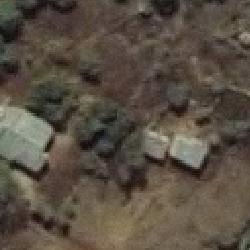

In [8]:
Image.open('Images/ID_0073qfb8.tif') # View one image and check the files are present

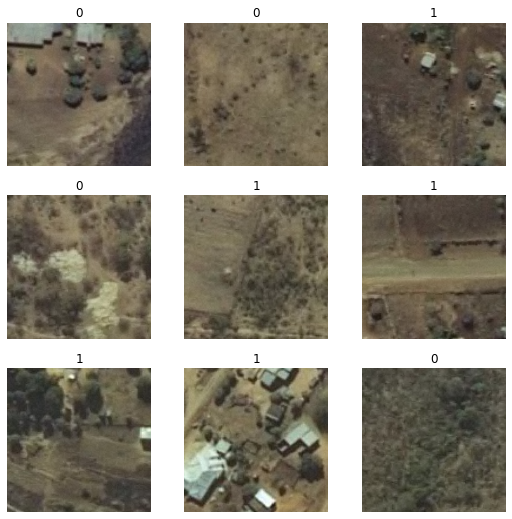

In [31]:
# Create the dataloaders
from fastai.vision import *
tfms = aug_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1, max_lighting=0.2, max_warp=0.)

# get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)

dls = ImageDataLoaders.from_df(train, 
                               path='Images',
                               suff='.tif',
                               bs=32,
                               tfms=tfms,
                               seed=42,
                               valid_pct=0.15,
                               device="cuda"
                               ) 
dls.show_batch() # View a batch with labels

# Training the Model

In [46]:
learn = cnn_learner(dls, 
                    vgg19_bn, 
                    lr=0.001,
                    metrics=error_rate,
                    wd=0.0005
                    )


In [47]:
learn.fine_tune(2, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.772679,0.523864,0.217143,02:09


epoch,train_loss,valid_loss,error_rate,time
0,0.566477,0.400823,0.172381,02:49
1,0.375104,0.394748,0.165714,02:50


# Making and Saving Predictions

We make a test dataloader, get the predicted probabilities and shape them into the format Zindi wants. I hope this sort of makes sense :)

In [48]:
# Load the test data
test = pd.read_csv('Test.csv')
test.head(3)

,Image_ID
0,ID_01c6i2wd
1,ID_03sPqBLY
2,ID_06ZKUQFl


In [49]:
# Check format
ss = pd.read_csv('SampleSubmission.csv')
ss.head(3)

,Image_ID,Target
0,ID_01c6i2wd,NaN
1,ID_03sPqBLY,NaN
2,ID_06ZKUQFl,NaN


In [50]:
# Make a test dataloader and get predictions
tdl = learn.dls.test_dl(test['Image_ID'].map(lambda s: 'Images/'+s+'.tif').values)
preds = learn.get_preds(dl=tdl)

In [51]:
# Store the predicted probabilities (we want P(Target=1))
test['Target'] = [float(p[1]) for p in preds[0]]
test.head()

,Image_ID,Target
0,ID_01c6i2wd,0.567898
1,ID_03sPqBLY,0.715269
2,ID_06ZKUQFl,0.999808
3,ID_06gzqIwK,0.001352
4,ID_08kWat36,0.774217


In [52]:
# Save
test.to_csv('submission-0.394748_valloss.csv', index=False)

In [53]:
os.listdir()

['Images.zip',
 'SampleSubmission.csv',
 'Test.csv',
 'Train.csv',
 'Images',
 '__MACOSX',
 'submission-0.403963_valloss.csv',
 'submission-0.394748_valloss.csv']